# Tips for developing reliable, consistent, and efficient analysis and plotting practices
- Always save your source data (e.g., to json, pickle, h5, csv).
- Record as many mutable analysis parameters as possible (e.g., using dictionaries and/or named tuples).
- Plot from saved data files.

In [ ]:
from collections import namedtuple
import json
from pathlib import Path
import time
import warnings

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

-------------------------------------------
## Linclab plot utilities

In [ ]:
# @title Git clone linclab_utils from GitHub
# @markdown `!git clone https://github.com/linclab/linclab_utils.git`
# https://github.com/linclab/linclab_utils/blob/main/plot_utils.py
from pathlib import Path
if not Path("linclab_utils").exists():
    !git clone https://github.com/linclab/linclab_utils.git --quiet

In [ ]:
from linclab_utils import plot_utils

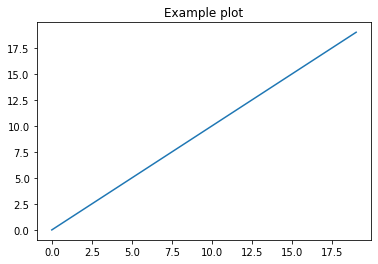

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(20))
_ = ax.set_title("Example plot")

In [ ]:
# @title Load linclab plotting settings

# @markdown `plot_utils.linclab_plt_defaults(font="Arial", fontdir="fonts")`

# download fonts from google drive folder...
!wget 'https://docs.google.com/uc?export=download&id=1eyf90hWNMXX5VezGPhlUZ-DwC2kv1noq' -O fonts.tar.gz --quiet
!tar -xzf fonts.tar.gz fonts
!\rm fonts.tar.gz

plot_utils.linclab_plt_defaults(font="Arial", fontdir="fonts")

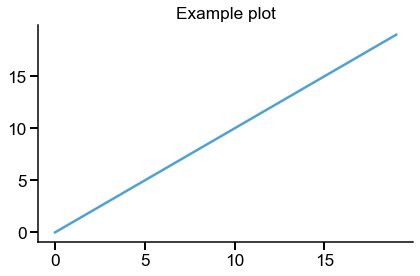

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(20))
_ = ax.set_title("Example plot")

-----------------------------------------------------
## Storing analysis parameters
- Light-weight
- Storable

### Dictionaries
- Flexible
- Mutable

In [ ]:
# @markdown `run_mini_analysis(analysis_params)`
def run_mini_analysis(analysis_params):
    analysis_params["stat"] = "median"
    print("Mini analysis successful.")

In [ ]:
analysis_params = {
    "win_size": 5,
    "stat"    : "mean",
    "error"   : "SEM",
    "seed"    : 45,
}
print(analysis_params)

# Key mistake
# analysis_params["winsize"] = 7
# print(analysis_params)

# Function that changes dictionary
# run_mini_analysis(analysis_params)
# print(analysis_params)

{'win_size': 5, 'stat': 'mean', 'error': 'SEM', 'seed': 45}


### Named tuples for storing analysis parameters
- Well-defined attributes
- Immutable

In [ ]:
from collections import namedtuple

In [ ]:
AnalysisParams = namedtuple("AnalysisParams", ["win_size", "stat", "error", "seed"])
analysis_params = AnalysisParams(5, "mean", "SEM", 45)

print(analysis_params)

AnalysisParams(win_size=5, stat='mean', error='SEM', seed=45)


In [ ]:
# @title Function for initializing analysis parameter namedtuple
# @markdown `analysis_params = init_analysis_params(win_size=5, stat="mean", error="SEM", seed=None)`

def init_analysis_params(win_size=5, stat="mean", error="SEM", seed=None):
    """
    Returns a analysis_params namedtuple with the inputs arguments as named 
    attributes.

    Optional args:
        - win_size (int):
            window size
            default: 5
        - stat (str): 
            statistic parameter ("mean" or "median")
            default: "mean"
        - error (str): 
            error statistic parameter ("std" or "SEM")
            default: "sem"
        - seed (int or None):
            random seed
            default: None

    Returns:
        - analysis_params (analysis_params namedtuple): 
            analysis_params with input arguments as attributes
    """

    values = [win_size, stat, error, seed]
    attributes = ["win_size", "stat", "error", "seed"]

    AnalysisParams  = namedtuple("analysis_params", attributes)
    analysis_params = AnalysisParams(*values)

    if stat == "median" and error.lower() in ["sem", "std"]:
        warnings.warn(
            "\n\nIn real life, of course, medians should NOT be paired with "
            "standard deviations or standard errors, but with related robust "
            "error metrics like IQRs and/or MADs.\n")

    return analysis_params
  

In [ ]:
analysis_params = init_analysis_params(
    win_size=5,
    stat="mean", 
    error="SEM", 
    seed=45, 
    )

print(analysis_params)
print(analysis_params.stat)
# analysis_params.error = "std"

analysis_params(win_size=5, stat='mean', error='SEM', seed=45)
mean


-----------------------------------------------------
# Toy example

## Initialize hyperparameters

In [ ]:
analysis_params = init_analysis_params(win_size=5, stat="mean", error="SEM", seed=45)

## Define functions

In [ ]:
# @title Function for elaborately producing complex data dataframe
# @markdown `df = complex_elaborate_analysis_fct(source_data, analysis_params, wait=45)`

def complex_elaborate_analysis_fct(source_data, analysis_params, wait=45):
    rst = np.random.RandomState(analysis_params.seed)

    # elaborate computation
    time.sleep(wait)

    data_types = [
        "trampoline prices", "learning rate", "broth density", "resonance", 
        "advanced metric"
        ]
    df = pd.DataFrame(columns=data_types)

    win_size = int(analysis_params.win_size)

    if source_data is None:
        # get a cosine-like base function
        n_pts = 20
        x_uniform = np.linspace(0, np.pi * 3, n_pts)
        y_uniform = np.sin(x_uniform) * 2
        x = np.sort(rst.random(n_pts)) * np.pi * 3
        source_data = np.interp(x, x_uniform, y_uniform)
    else:
        n_pts = len(source_data)

    prev = source_data
    for data_type in data_types:
        relatedness = rst.random(1)
        data = rst.random(n_pts) * 1.5
        if rst.random(1) > 0.5:
            prev = -prev
        data = data + prev * relatedness
        prev = data
        # window data
        df[data_type] = np.convolve(
            data, np.ones(win_size)/win_size, mode="valid"
            )
                
    # take statistics
    all_data = df.to_numpy()
    if analysis_params.stat == "mean":
        stat = np.mean(all_data, axis=1)
    elif analysis_params.stat == "median":
        stat = np.median(all_data, axis=1)
    else:
      raise ValueError(f"statpar.stat={statpar.stat}, but expected 'mean' or 'median'.")

    if analysis_params.error.lower() == "std":
        error = np.std(all_data, axis=1)
    elif analysis_params.error.lower() == "sem":
        error = scipy.stats.sem(all_data, axis=1)
    else:
      raise ValueError(f"statpar.error={statpar.error}, but expected 'std' or 'SEM'.")

    df["stat"] = stat
    df["error"] = error

    return df

In [ ]:
# @title Function for defining save paths
# @markdown `save_path = get_save_path(analysis_params, save_type="data")`

def get_save_path(analysis_params, save_type="data"):

    if isinstance(analysis_params, dict):
        analysis_params = init_analysis_params(**analysis_params)

    save_path = f"elaborate_win{analysis_params.win_size}_{analysis_params.stat}_{analysis_params.error.lower()}"
    if analysis_params.seed is not None:
        save_path = f"{save_path}_seed{analysis_params.seed}"

    if save_type == "data":
        save_path = f"{save_path}.json"
    elif save_type == "fig":
        save_path = f"{save_path}.svg"
    else:
        raise ValueError(f"save_path={save_path}, but expected 'data' or 'fig'.")

    return Path(save_path)


## Run analysis

In [ ]:
data_df = complex_elaborate_analysis_fct(source_data=None, analysis_params=analysis_params, wait=5)
data_df.head()

,trampoline prices,learning rate,broth density,resonance,advanced metric,stat,error
0,1.127747,-0.242233,0.531608,1.303216,1.084458,0.760959,0.282155
1,1.341458,-0.297445,0.578611,1.310687,1.086674,0.803997,0.307366
2,1.243214,-0.224480,0.766694,1.633038,1.060999,0.895893,0.313305
3,1.031681,-0.260781,0.968004,1.621377,0.988564,0.869769,0.307655
4,0.653642,-0.119490,0.872034,1.622360,1.018552,0.809420,0.282460


## Save analysis results and parameters

In [ ]:
save_path = get_save_path(analysis_params, save_type="data")
print(save_path)

elaborate_win5_mean_sem_seed45.json


In [ ]:
import json

save_info = {
    "analysis_params": analysis_params._asdict(), # save as dictionary
    "data_df" : data_df.to_dict(), # save as dictionary
}

with open(save_path, "w") as f:
    json.dump(save_info, f)

## Plot from saved data
- Have your plot function take saved file keys as input, for convenience.
- Use object-oriented plotting.

In [ ]:
# @title Function for plotting from elaborate data dataframe
# @markdown `fig = plot_complex_elaborate_data_df(analysis_params, data_df, save=True)`

MARKERS = ["X", "o", "^", "d", "s", "h"]
CMAP = plot_utils.linclab_colormap(no_white=True)

def plot_complex_elaborate_data_df(analysis_params, data_df, save=True):

    # reload dictionaries into original objects, if needed
    if isinstance(data_df, dict):
        data_df = pd.DataFrame.from_dict(data_df) 
    if isinstance(analysis_params, dict):
        analysis_params = init_analysis_params(**analysis_params)

    fig, ax = plt.subplots(1, figsize=[15, 9])
    n_cols = len(data_df.columns) - 2
    colors = CMAP(np.linspace(0, 1, n_cols))

    markersize = 16
    c = 0
    for d, data_type in enumerate(data_df.columns):
        marker = MARKERS[d % len(MARKERS)]

        if data_type not in ["stat", "error"]:
            ax.plot(
                data_df[data_type], 
                label=data_type.capitalize(), # legend label
                marker=marker, 
                markersize=markersize, 
                alpha=0.5, # transparency
                color=colors[c], 
                lw=5 # linewidth
                )
            c += 1

        elif data_type == "stat":
            stat = data_df[data_type]
            err = data_df["error"]
            x = np.arange(len(stat))
            
            # create a legend label
            label = u"{} {} {}".format(
                analysis_params.stat, 
                u"\u00B1", 
                analysis_params.error
                )
            if analysis_params.stat == "median":
                label = u"{} (!?)".format(label)
            
            # plot statistic as a line
            line = ax.plot(
                stat, 
                label=label.capitalize(), # legend label
                marker=marker, 
                markersize=markersize,
                alpha=0.7, # transparency
                color="black",
                lw=7, # linewidth
                )
            
            # plot shading for error
            ax.fill_between(
                x, 
                y1=stat - err, 
                y2=stat + err, 
                color=line[-1].get_color(), # just use same color as statistic line
                alpha=0.3 # transparency
                )
            
    # create the title from the parameters
    seed_str = ""
    if analysis_params.seed is not None:
      seed_str = f", seed={analysis_params.seed}"
    title = (f"Complex and elaborate data analysis results "
      f"(win={analysis_params.win_size}{seed_str})")

    # increase the upper y limit
    ylims = ax.get_ylim()
    ax.set_ylim([ylims[0], ylims[1] * 1.3])

    # adjust the plot
    ax.legend(fontsize="large") # bigger legend text
    ax.set_title(title, y=1.1, fontsize="xx-large") # larger title
    ax.set_xlabel("Fortnights") # x axis label
    ax.set_ylabel("A.U.") # y axis label
    

    if save:
        save_path = get_save_path(analysis_params, save_type="fig")
        fig.savefig(
            save_path,
            transparent=False # save with opaque background
            )

    return fig, ax

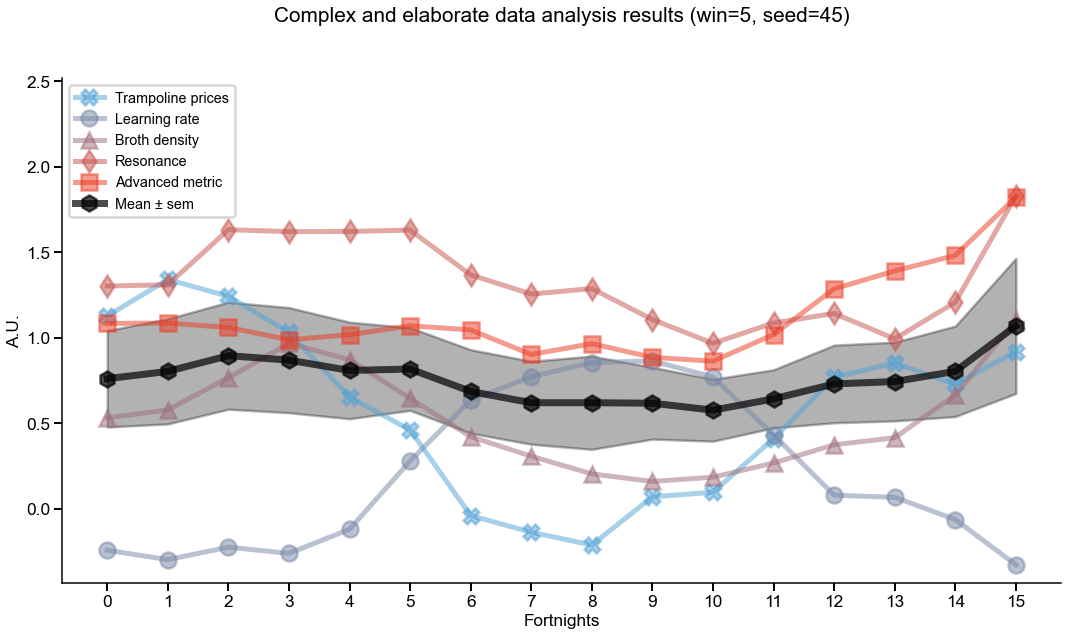

In [ ]:
save_path = get_save_path(analysis_params, save_type="data")
with open(save_path, "r") as f:
    save_info = json.load(f)

fig, ax = plot_complex_elaborate_data_df(save=True, **save_info)

### Examples of additional modifications to the plot
- Many of these changes can be implemented by modifying the default parameter settings for pyplot.
- Although the linclab default settings tend to produce reasonable plot sizes, this plot is very large, so we will increase them further.
- These plots are meant to provide examples of how to use `pyplot` effectively (**_not_** examples of aesthetically ideal figures).

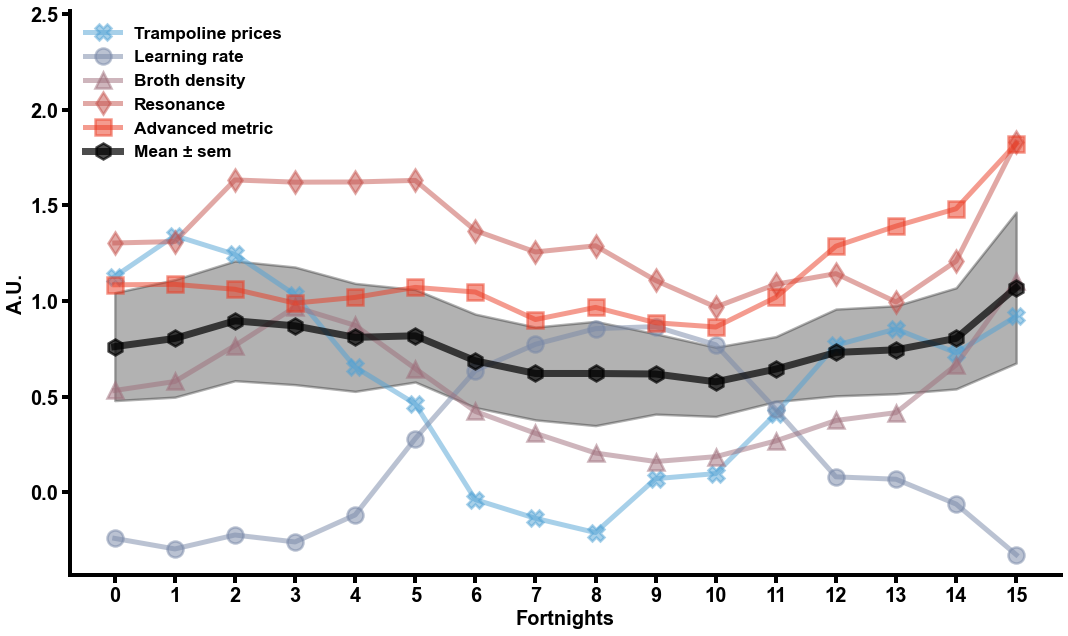

In [ ]:
overwrite_fig = True

spine_tick_lw = 4
label_fs = 20
legend_fs = 14

# general
ax.set_title("") # remove the title
ax.spines["left"].set_linewidth(spine_tick_lw) # make the lines thicker
ax.spines["bottom"].set_linewidth(spine_tick_lw)

# legend
ax.legend(frameon=False, fontsize=legend_fs, prop={"weight": "bold"})

# y axis
ax.set_ylabel(ax.get_ylabel(), fontweight="bold", fontsize=label_fs)
ax.set_yticklabels(ax.get_yticklabels(), weight="bold", fontsize=label_fs)
ax.yaxis.set_tick_params(width=spine_tick_lw)

# x axis
ax.set_xlabel(ax.get_xlabel(), fontweight="bold", fontsize=label_fs)
ax.set_xticklabels(ax.get_xticklabels(), weight="bold", fontsize=label_fs)
ax.xaxis.set_tick_params(width=spine_tick_lw)

if overwrite_fig: # save this new copy of the figure
    save_path = get_save_path(analysis_params, save_type="fig")
    fig.savefig(
        save_path,
        transparent=False # save with opaque background
        )

fig

# Summary

### Advantages
- **Reliability:** Saving data and parameters ensures that **you know** and can **verify** exactly what you've plotted, both in terms of actual data, and the parameters involved in generating the data.
- **Consistency:** Using objects like named tuples ensures consistency across different version of the same analysis, as well as automatic plot labelling and generation of save paths.
- **Efficiency:** Plotting from saved files enables rapid iteration on and mass updating of plots.

### Caveats
- **Extra work:** Using objects like named tuples can be more work up front. Really pays off when there are many consistent mutable parameters to keep track of. 
- **Data saving challenges:** Json files are convenient, since they are much more compact than yaml files, and readable with a standard text editor, unlike pickles. However, data saving can be very finnicky with json. This is compounded when using dataframes converted to dictionaries, which can easily contain stray numpy arrays or datatypes that are not json serializable.
